In [4]:
!pip install pandas

     --------------------------------------- 11.2/11.2 MB 11.3 MB/s eta 0:00:00
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
     -------------------------------------- 341.8/341.8 kB 7.1 MB/s eta 0:00:00


### Run Using actor_crtic environment

In [5]:
import utm
import math
import time
import torch
import numpy as np
import pandas as pd

In [40]:
df = pd.read_csv('./data/Central_Delhi_150.csv')  
df.head()

,hub_name,customer_id,ofd_date,buyer_lat,buyer_long,Buyer_pincode,weight(Kg),rts_wt(Kg),transaction_time(mins),delivery_slot_start,delivery_slot_end,hub_lat,hub_long
0,Central_Delhi,c_110005_0,2021-11-17,28.654342,77.206996,110005,375.26,0,10,4 PM,7 PM,28.657814,77.219964
1,Central_Delhi,c_110007_1,2021-11-17,28.676079,77.208478,110007,4.81,0,5,7 AM,10 AM,28.657814,77.219964
2,Central_Delhi,c_110002_2,2021-11-17,28.649771,77.261710,110002,248.46,0,10,4 PM,7 PM,28.657814,77.219964
3,Central_Delhi,c_110008_3,2021-11-17,28.673088,77.156000,110008,196.53,0,10,10 AM,1 PM,28.657814,77.219964
4,Central_Delhi,c_110009_4,2021-11-17,28.703417,77.175337,110009,63.66,0,7,4 PM,7 PM,28.657814,77.219964


In [41]:
df.head().to_latex(index = False, multirow = True)

'\\begin{tabular}{lllrrrrrrllrr}\n\\toprule\nhub_name & customer_id & ofd_date & buyer_lat & buyer_long & Buyer_pincode & weight(Kg) & rts_wt(Kg) & transaction_time(mins) & delivery_slot_start & delivery_slot_end & hub_lat & hub_long \\\\\n\\midrule\nCentral_Delhi & c_110005_0 & 2021-11-17 & 28.654342 & 77.206996 & 110005 & 375.260000 & 0 & 10 & 4 PM & 7 PM & 28.657814 & 77.219964 \\\\\nCentral_Delhi & c_110007_1 & 2021-11-17 & 28.676079 & 77.208478 & 110007 & 4.810000 & 0 & 5 & 7 AM & 10 AM & 28.657814 & 77.219964 \\\\\nCentral_Delhi & c_110002_2 & 2021-11-17 & 28.649771 & 77.261710 & 110002 & 248.460000 & 0 & 10 & 4 PM & 7 PM & 28.657814 & 77.219964 \\\\\nCentral_Delhi & c_110008_3 & 2021-11-17 & 28.673088 & 77.156000 & 110008 & 196.530000 & 0 & 10 & 10 AM & 1 PM & 28.657814 & 77.219964 \\\\\nCentral_Delhi & c_110009_4 & 2021-11-17 & 28.703417 & 77.175337 & 110009 & 63.660000 & 0 & 7 & 4 PM & 7 PM & 28.657814 & 77.219964 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [42]:
#Adding depot at the start
coords= [df.loc[0,['hub_lat','hub_long']].values.tolist()] + df[['buyer_lat','buyer_long']].values.tolist()
dynamic = [0] + df['weight(Kg)'].values.tolist()

In [43]:
def distance1(x1,y1,x2,y2):
    """
    Calculate the distance between two nodes
    """
    d1=x1-x2
    d2=y1-y2
    out=math.sqrt(d1*d1+d2*d2)
    return(out)

In [44]:
def convert_to_coordinate(coords):
    """
    Convert the latitude and longitude to x,y coordinate
    """
    ans = []
    for i in coords:
        x,y,_,_ = utm.from_latlon(i[0],i[1])
        ans.append((x,y))
    return ans 

In [45]:
def normalize_demand(demands):
    """
    To Normalize the demand  max_demand should be 9 
    and max vehicle capacity is 40 
    """
    max_load = 9
    max_capacity = 40
    return ((demands/(np.max(demands)))*max_load)/max_capacity

In [46]:
def normalize_coordinates(coords):
    # Extract x and y values into separate arrays
    x_vals = np.array([coord[0] for coord in coords])
    y_vals = np.array([coord[1] for coord in coords])

    # Compute translation and shifting
    x_min, y_min = x_vals.min(), y_vals.min()
    x_vals = x_vals-x_min
    y_vals = y_vals-y_min

    # calculating max distance
    max_distance = 0
    for x1,y1 in zip(x_vals,y_vals):
        for x2,y2 in zip(x_vals,y_vals):
            max_distance = max(max_distance,distance1(x1,y1,x2,y2))

    #scaling
    transformed_coords = []
    for x,y in zip(x_vals,y_vals):
        transformed_coords.append((x/max_distance,y/max_distance))
    return transformed_coords

In [47]:
dynamic = normalize_demand(dynamic)
coords = convert_to_coordinate(coords)
coords = normalize_coordinates(coords)

In [48]:
static = torch.tensor(coords)
dynamic = torch.Tensor(dynamic)

#reshaping the dynamic such that it has shape of (1,1,num_nodes)
dynamic = dynamic.reshape((1,1,-1))

#adding vehicle capacity to all the nodes
dynamic = torch.tensor(np.concatenate((torch.full(dynamic.shape,1), dynamic), axis=1))

static = static.T
static = static.unsqueeze(dim=0)

#Getting depot location for the model
x0 = static[:,:,0]
x0 = x0.unsqueeze(dim=2)

In [49]:
print(f'static shape {static.shape}')
print(f'x0 shape : {x0.shape}')
print(f'dynamic shape : {dynamic.shape}')

static shape torch.Size([1, 2, 301])
x0 shape : torch.Size([1, 2, 1])
dynamic shape : torch.Size([1, 2, 301])


In [50]:
import os
import torch
import numpy as  np
from Tasks import vrp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from Models.actor import DRL4TSP
from Models.critc import StateCritic
from Tasks.vrp import VehicleRoutingDataset
from vrp_ortools import solve_ortools,solve_ortools_time

In [51]:
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print('Detected device {}'.format(device))
#For error removing
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled=False

Detected device cpu


In [52]:
#Hyperparameter
LOAD_DICT={10:20,20:30,50:40,100:50}
MAX_DEMAND=9
STATIC_SIZE=2 #(x,y)
DYNAMIC_SIZE=2 #(load,demand)
seed=42

In [53]:
hidden_size=128
num_layers=1
dropout=0.1

In [54]:
num_nodes=50
num_samples=1
max_load=LOAD_DICT[num_nodes]
test_data=VehicleRoutingDataset(num_samples,
                                num_nodes,
                                max_load,
                                MAX_DEMAND,
                                seed)

In [55]:
test_data.static.dtype

torch.float32

In [56]:
test_data.dynamic.dtype

torch.float32

In [57]:
static = static.to(torch.float32)
dynamic = dynamic.to(torch.float32)

In [58]:
test_data.static = static
test_data.dynamic = dynamic

In [59]:
batch_size=16
test_loader=DataLoader(test_data,batch_size,False,num_workers=0)

In [60]:
actor=DRL4TSP(STATIC_SIZE,
              DYNAMIC_SIZE,
              hidden_size,
              test_data.update_dynamic,
              test_data.update_mask,
              num_layers,
              dropout
              ).to(device)

In [61]:
path=r'vrp\50\actor.pt'
actor.load_state_dict(torch.load(os.path.join(os.getcwd(),path),device))

<All keys matched successfully>

In [62]:
def validate(data_loader, actor, reward_fn, render_fn=None, save_dir='.', num_plot=5):
    actor.eval()
    rewards=[]
    
    for batch_idx,batch in enumerate(data_loader):
        
        static, dynamic, x0 = batch
        
        static=static.to(device)
        dynamic=dynamic.to(device)
        x0=x0.to(device)
        
        with torch.no_grad():
            tour_indices,_ = actor.forward(static,dynamic,x0)
            
        
        reward=reward_fn(static,tour_indices).mean().item()
        rewards.append(reward)
        
        if render_fn is not None and batch_idx < num_plot:
            name = 'batch%d_%2.4f.png'%(batch_idx, reward)
            path = os.path.join(save_dir, name)
            render_fn(static, tour_indices)
        
    actor.train()
    return np.mean(rewards),tour_indices

In [63]:
def render_(static, tour_indices):
    """Plots the found solution."""

    plt.close('all')

    num_plots = 3 if int(np.sqrt(len(tour_indices))) >= 3 else 1

    _, axes = plt.subplots(nrows=num_plots, ncols=num_plots,
                           sharex='col', sharey='row')

    if num_plots == 1:
        axes = [[axes]]
    axes = [a for ax in axes for a in ax]

    for i, ax in enumerate(axes):

        # Convert the indices back into a tour
        
        idx = tour_indices[i]
        
        if len(idx.size()) == 1:
            idx = idx.unsqueeze(0)
        
        idx = idx.expand(static.size(1), -1)
        #print(f'static : {static[i]}')
        #print(f'idx = {idx}')
        
        data = torch.gather(static[i].data, 1, idx).cpu().numpy()
        #print(f'Data = {data}')
        
        start = static[i, :, 0].cpu().data.numpy()
        x = np.hstack((start[0], data[0], start[0]))
        y = np.hstack((start[1], data[1], start[1]))

        # Assign each subtour a different colour & label in order traveled
        idx = np.hstack((0, tour_indices[i].cpu().numpy().flatten(), 0))
        #print(f'idx = {idx}')
        where = np.where(idx == 0)[0]
        #print(where)
        for j in range(len(where) - 1):

            low = where[j]
            high = where[j + 1]

            if low + 1 == high:
                continue

            ax.plot(x[low: high + 1], y[low: high + 1], zorder=1, label=j)

        ax.legend(loc="upper right", fontsize=3, framealpha=0.5)
        ax.scatter(x, y, s=4, c='r', zorder=2)
        ax.scatter(x[0], y[0], s=20, c='k', marker='*', zorder=3)

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    plt.grid()
    plt.title('Routes Generated using RL')
    plt.tight_layout()
    plt.savefig('Route Generated using RL.png')
    plt.show()
    #plt.savefig(save_path, bbox_inches='tight', dpi=200)

In [64]:
def or_render(locations,route):
    #plt.figure(figsize=(7,6),dpi=100)
    route=[i for i in route if len(i)>2]
    for temp,i in enumerate(route):
        x=[locations[0][index] for index in i]
        y=[locations[1][index] for index in i]
        plt.plot(x,y,label='{}'.format(temp))
    plt.scatter(locations[0][1:],locations[1][1:],c='red',label='Customer')
    plt.scatter(locations[0][0],locations[1][0],marker='*',c='black',label='Depot')
    for i,t in enumerate(zip(locations[0],locations[1])):
        plt.annotate(i,t)
    plt.legend(loc=0)
    plt.title("Route Generated using OR Tool")
    plt.grid()
    plt.savefig('Route Generated using OR Tool.png')
    plt.show()

C:\Users\Admin\Downloads\VRP\VRP\RL-VRP-PtrNtwrk\Tasks\vrp.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor.data, device=dynamic.device)


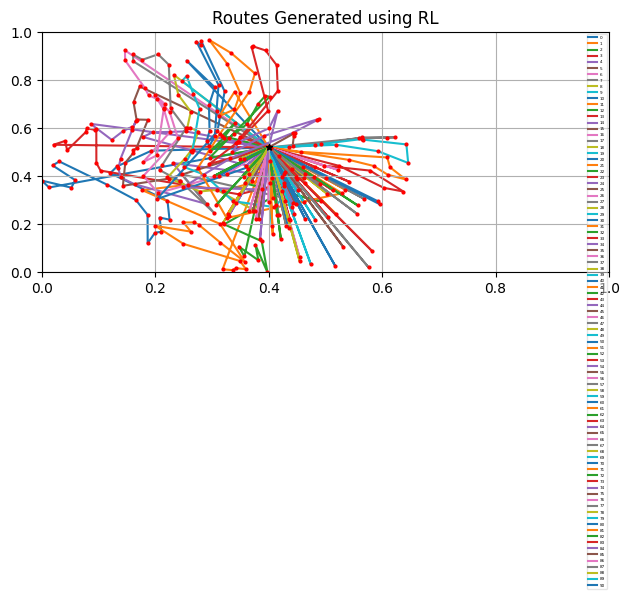

In [ ]:
start=time.time()
rl_distance, rl_routes = validate(test_loader, actor, vrp.reward,render_)
rl_time = time.time()-start
start = time.time()
static, demand, xo=test_data[0]
or_distance, or_routes = solve_ortools(static,demand[1],max_load,multiplier=1e4)
or_time = time.time()-start
print(f'The Total distance travelled by RL method is :{rl_distance : 0.3f} m and  time taken is {rl_time : 0.3f} sec')
print(f'The Total distance travelled by OR Tool method is :{or_distance : 0.3f} m and time taken is {or_time : 0.3f} sec' )

In [ ]:
or_render(static,or_routes)

The Total distance travelled by OR Tool method is : 10.165 m and time taken is  2.064 sec


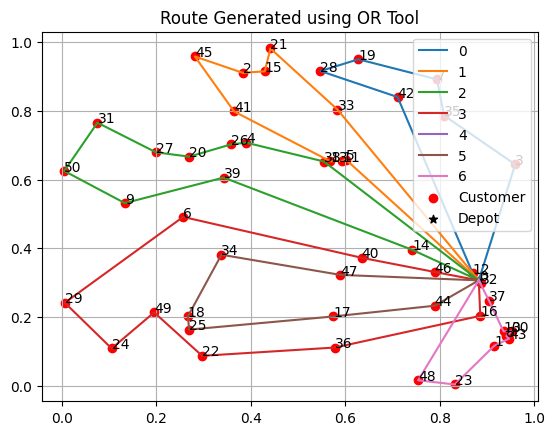

In [39]:
start = time.time()
static, demand, xo=test_data[0]
or_distance, or_routes = solve_ortools_time(static,demand[1],max_load,multiplier=1e4,time=2)
or_time = time.time()-start
print(f'The Total distance travelled by OR Tool method is :{or_distance : 0.3f} m and time taken is {or_time : 0.3f} sec' )
or_render(static,or_routes)